# Model Validation Tutorial #

Here is a short tutorial on different techniques to validate in depth your deep learning models. It is just a walkthrough of the different tools Moov AI uses.

Here are the different assessments that we will review together during the tutorial:
* Model Fit
* Discriminatory Features
* Sensitivity Assessment

## Exercise:## 
Without having much context about the deep learning model, being able to question its validity.

In [42]:
# basic packages
import pandas as pd
import numpy as np
from time import time
import warnings
#import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
#%matplotlib inline

# preprocessing packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# deep learning packages
from keras.models import model_from_json
import tensorflow as tf
tf.autograph.set_verbosity(3)

# simple metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# basic interpretability package
import shap

# basic adversarial example generator
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod

## We will interpret models only using final model and test data

In [43]:
def load_validation_input(path):
    X = np.load(path + '/X_test.npz', 'r', allow_pickle=True)
    X = np.array(X['arr_0'])
    
    feature_names = np.load(path + '/feature_names.npy', allow_pickle=True)

    y = np.load(path + '/y_test.npz', 'r', allow_pickle=True)
    y = np.array(y['arr_0'])
    print("Loaded test data")
    
    history = np.load(path + '/history.npy', allow_pickle=True)
    print("Loaded training history")
    
    json_file = open(path + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(path + '/model_weights.h5')
    print("Loaded model")
    
    loaded_model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return X, y, history, loaded_model, feature_names

## Let's validate our first model

In [44]:
X_test, y_test, history, loaded_model, feature_names = load_validation_input('model_0')

Loaded test data
Loaded training history
Loaded model


In [45]:
x = ['Accuracy on training data', 'training of validation data', 'training on test data']
y = [np.min(history[0]), np.min(history[1]), loaded_model.evaluate(x=X_test, y=y_test)[0]]

# Use textposition='auto' for direct text
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])
fig.update_layout(title='loss by sample', yaxis_title='loss')
fig.show()

18437/18437 [==============================] - 1s 42us/step


In [46]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 70)                1610      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 70)                4970      
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 70)                4970      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 213       
Total para

In [47]:
#fit data
epochs = np.arange(1, history.shape[1] +1, 1)
loss = history[0]
val_loss = history[1]
test_training_margin = np.absolute(val_loss - loss) / loss

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=epochs, y=loss, name='loss', line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, name='val_loss', line=dict(color='royalblue', width=4)))

# Edit the layout
fig.update_layout(title='loss progression by epoch', xaxis_title='epoch', yaxis_title='loss')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=test_training_margin, name='test_training_margin', line=dict(color='firebrick', width=4)))
fig.update_layout(title='loss margin between validation and training by epoch', xaxis_title='epoch', yaxis_title='testing to validation margin')
fig.show()

In [48]:
y_class = np.array([np.argmax(i) for i in y_test])
confusion_matrice_table = confusion_matrix(y_class, loaded_model.predict_classes(X_test), labels=[0, 1, 2])
confusion_matrice_table = np.array([confusion_matrice_table[i,:] / sum(confusion_matrice_table[i,:]) for i in range(y_test.shape[1])])

categories = ['Good Quality', 'Warning', 'Quality Issue']
fig = go.Figure(data=go.Heatmap(z=confusion_matrice_table, x=categories, y=categories, colorscale='Viridis'))
fig.update_layout(title='Normalized Confusion Matrix - Accuracy', xaxis_title='Predicted Label', yaxis_title='True Label')
fig.show()

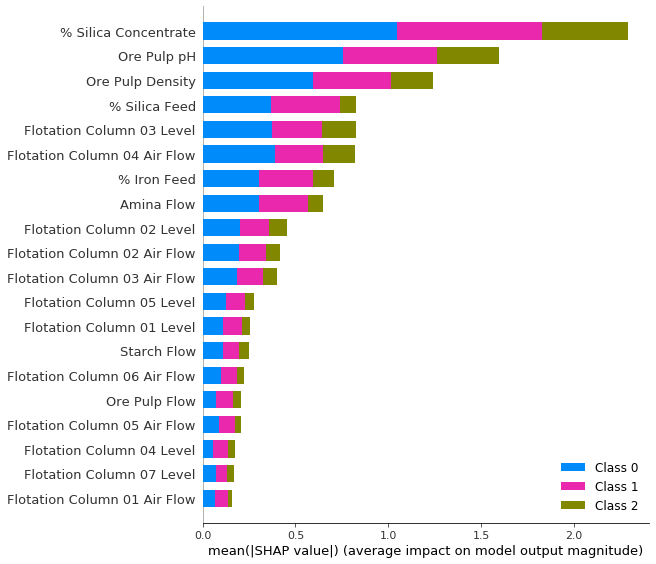

In [49]:
# Interpretability
background = X_test[:20]
e = shap.DeepExplainer(loaded_model, background)
shap_values = e.shap_values(X_test)
shap.summary_plot(shap_values, X_test[100], feature_names=feature_names ,plot_type="bar")

In [50]:
#Create classifier to identify the decision boundaries
classifier = KerasClassifier(model=loaded_model, use_logits=False)
probs_adv = classifier.predict(X_test)

print('Training of ART classifier')
classifier.fit(X_test, y_test, batch_size=32, nb_epochs=5, verbose = 0)
#Evaluate the ART classifier on benign test examples
predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

#Generate adversarial test examples
print('Creation of adversarial examples')
attack = FastGradientMethod(classifier=classifier, eps=0.05)
x_test_adv = attack.generate(x=X_test)
predictions = classifier.predict(x_test_adv)
adv_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Adversarial examples created')

Training of ART classifier
Creation of adversarial examples
Adversarial examples created


In [51]:
fig = go.Figure(go.Waterfall(
    x = ['Accuracy on benign test examples', 'Impact on accuracy', 'Accuracy on adversarial examples'],
    measure = ['absolute', 'relative', 'absolute'], y = [accuracy, adv_accuracy - accuracy, adv_accuracy],
    decreasing = {"marker":{"color":"Maroon", "line":{"color":"red", "width":2}}},
    increasing = {"marker":{"color":"Teal"}},
    totals = {"marker":{"color":"deep sky blue", "line":{"color":'blue', "width":3}}}
))

fig.update_layout(title = "Accuracy Difference with Benign and Adversarial (5% Noise) Examples", yaxis_title='Accuracy', waterfallgap = 0.3)

fig.show()

In [52]:
adv_median_change = []
for i in range(X_test.shape[1]):
    adv_median_change.append(np.mean((X_test - x_test_adv)[:,i]))
    
fig = go.Figure(go.Bar(
            x=adv_median_change,
            y=feature_names,
            orientation='h'))

fig.update_layout(title = "Average Impact of adversarial noise", xaxis_title='average feature change to generate 5% adversarial noise', waterfallgap = 0.3)

fig.show()

# What's your verdict about the model?

## Let's test another model

In [53]:
X_test, y_test, history, loaded_model, feature_names = load_validation_input('model_1')

Loaded test data
Loaded training history
Loaded model


In [54]:
x = ['Accuracy on training data', 'training of validation data', 'training on test data']
y = [np.min(history[0]), np.min(history[1]), loaded_model.evaluate(x=X_test, y=y_test)[0]]

# Use textposition='auto' for direct text
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])
fig.update_layout(title='loss by sample', yaxis_title='loss')
fig.show()

18437/18437 [==============================] - 1s 47us/step


In [55]:
#fit data
epochs = np.arange(1, history.shape[1] +1, 1)
loss = history[0]
val_loss = history[1]
test_training_margin = np.absolute(val_loss - loss) / loss

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=epochs, y=loss, name='loss', line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, name='val_loss', line=dict(color='royalblue', width=4)))

# Edit the layout
fig.update_layout(title='loss progression by epoch', xaxis_title='epoch', yaxis_title='loss')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=test_training_margin, name='test_training_margin', line=dict(color='firebrick', width=4)))
fig.update_layout(title='loss margin between validation and training by epoch', xaxis_title='epoch', yaxis_title='testing to validation margin')
fig.show()

In [56]:
y_class = np.array([np.argmax(i) for i in y_test])
confusion_matrice_table = confusion_matrix(y_class, loaded_model.predict_classes(X_test), labels=[0, 1, 2])
confusion_matrice_table = np.array([confusion_matrice_table[i,:] / sum(confusion_matrice_table[i,:]) for i in range(y_test.shape[1])])

categories = ['Good Quality', 'Warning', 'Quality Issue']
fig = go.Figure(data=go.Heatmap(z=confusion_matrice_table, x=categories, y=categories, colorscale='Viridis'))
fig.update_layout(title='Normalized Confusion Matrix - Accuracy', xaxis_title='Predicted Label', yaxis_title='True Label')
fig.show()

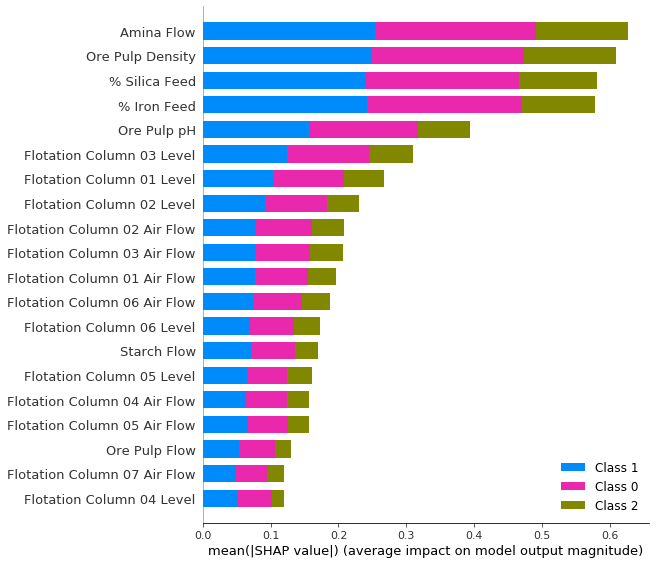

In [57]:
# Interpretability
background = X_test[:20]
e = shap.DeepExplainer(loaded_model, background)
shap_values = e.shap_values(X_test)
shap.summary_plot(shap_values, X_test[100], feature_names=feature_names ,plot_type="bar")

In [58]:
#Create classifier to identify the decision boundaries
classifier = KerasClassifier(model=loaded_model, use_logits=False)
probs_adv = classifier.predict(X_test)

print('Training of ART classifier')
classifier.fit(X_test, y_test, batch_size=32, nb_epochs=5, verbose = 0)
#Evaluate the ART classifier on benign test examples
predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

#Generate adversarial test examples
print('Creation of adversarial examples')
attack = FastGradientMethod(classifier=classifier, eps=0.05)
x_test_adv = attack.generate(x=X_test)
predictions = classifier.predict(x_test_adv)
adv_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Adversarial examples created')

Training of ART classifier
Creation of adversarial examples
Adversarial examples created


In [59]:
fig = go.Figure(go.Waterfall(
    x = ['Accuracy on benign test examples', 'Impact on accuracy', 'Accuracy on adversarial examples'],
    measure = ['absolute', 'relative', 'absolute'], y = [accuracy, adv_accuracy - accuracy, adv_accuracy],
    decreasing = {"marker":{"color":"Maroon", "line":{"color":"red", "width":2}}},
    increasing = {"marker":{"color":"Teal"}},
    totals = {"marker":{"color":"deep sky blue", "line":{"color":'blue', "width":3}}}
))

fig.update_layout(title = "Accuracy Difference with Benign and Adversarial (5% Noise) Examples", yaxis_title='Accuracy', waterfallgap = 0.3)

fig.show()

In [60]:
adv_median_change = []
for i in range(X_test.shape[1]):
    adv_median_change.append(np.mean((X_test - x_test_adv)[:,i]))
    
fig = go.Figure(go.Bar(
            x=adv_median_change,
            y=feature_names,
            orientation='h'))

fig.update_layout(title = "Average Impact of adversarial noise", xaxis_title='average feature change to generate 5% adversarial noise', waterfallgap = 0.3)

fig.show()

In [61]:
y_class = np.array([np.argmax(i) for i in y_test])
confusion_matrice_table = confusion_matrix(y_class, loaded_model.predict_classes(X_test), labels=[0, 1, 2])
confusion_matrice_table = np.array([confusion_matrice_table[i,:] / sum(confusion_matrice_table[i,:]) for i in range(y_test.shape[1])])

categories = ['Good Quality', 'Warning', 'Quality Issue']
fig = go.Figure(data=go.Heatmap(z=confusion_matrice_table, x=categories, y=categories, colorscale='Viridis'))
fig.update_layout(title='Normalized Confusion Matrix - Accuracy', xaxis_title='Predicted Label', yaxis_title='True Label')
fig.show()

## Let's try a third one!

## Let's test another model

In [62]:
X_test, y_test, history, loaded_model, feature_names = load_validation_input('model_4')

Loaded test data
Loaded training history
Loaded model


In [63]:
x = ['Accuracy on training data', 'training of validation data', 'training on test data']
y = [np.min(history[0]), np.min(history[1]), loaded_model.evaluate(x=X_test, y=y_test)[0]]

# Use textposition='auto' for direct text
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])
fig.update_layout(title='loss by sample', yaxis_title='loss')
fig.show()

18437/18437 [==============================] - 1s 56us/step


In [64]:
#fit data
epochs = np.arange(1, history.shape[1] +1, 1)
loss = history[0]
val_loss = history[1]
test_training_margin = np.absolute(val_loss - loss) / loss

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=epochs, y=loss, name='loss', line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, name='val_loss', line=dict(color='royalblue', width=4)))

# Edit the layout
fig.update_layout(title='loss progression by epoch', xaxis_title='epoch', yaxis_title='loss')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=test_training_margin, name='test_training_margin', line=dict(color='firebrick', width=4)))
fig.update_layout(title='loss margin between validation and training by epoch', xaxis_title='epoch', yaxis_title='testing to validation margin')
fig.show()

In [65]:
y_class = np.array([np.argmax(i) for i in y_test])
confusion_matrice_table = confusion_matrix(y_class, loaded_model.predict_classes(X_test), labels=[0, 1, 2])
confusion_matrice_table = np.array([confusion_matrice_table[i,:] / sum(confusion_matrice_table[i,:]) for i in range(y_test.shape[1])])

categories = ['Good Quality', 'Warning', 'Quality Issue']
fig = go.Figure(data=go.Heatmap(z=confusion_matrice_table, x=categories, y=categories, colorscale='Viridis'))
fig.update_layout(title='Normalized Confusion Matrix - Accuracy', xaxis_title='Predicted Label', yaxis_title='True Label')
fig.show()

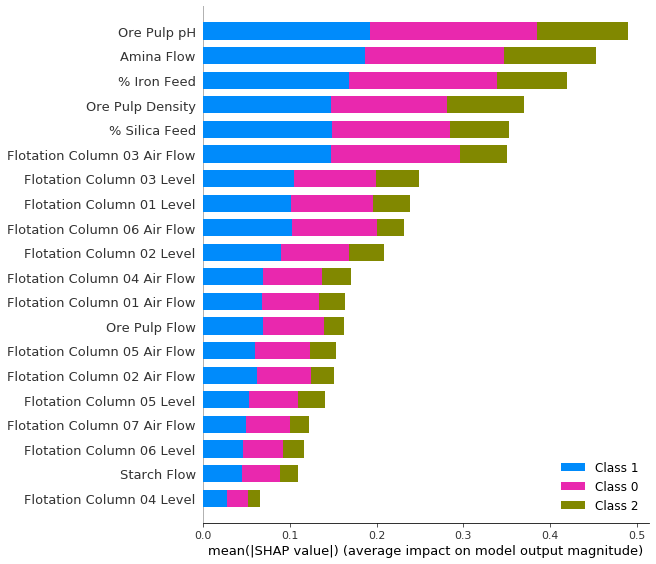

In [66]:
# Interpretability
background = X_test[:20]
e = shap.DeepExplainer(loaded_model, background)
shap_values = e.shap_values(X_test)
shap.summary_plot(shap_values, X_test[100], feature_names=feature_names ,plot_type="bar")

In [67]:
#Create classifier to identify the decision boundaries
classifier = KerasClassifier(model=loaded_model, use_logits=False)
probs_adv = classifier.predict(X_test)

print('Training of ART classifier')
classifier.fit(X_test, y_test, batch_size=32, nb_epochs=5, verbose = 0)
#Evaluate the ART classifier on benign test examples
predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

#Generate adversarial test examples
print('Creation of adversarial examples')
attack = FastGradientMethod(classifier=classifier, eps=0.05)
x_test_adv = attack.generate(x=X_test)
predictions = classifier.predict(x_test_adv)
adv_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Adversarial examples created')

Training of ART classifier
Creation of adversarial examples
Adversarial examples created


In [68]:
fig = go.Figure(go.Waterfall(
    x = ['Accuracy on benign test examples', 'Impact on accuracy', 'Accuracy on adversarial examples'],
    measure = ['absolute', 'relative', 'absolute'], y = [accuracy, adv_accuracy - accuracy, adv_accuracy],
    decreasing = {"marker":{"color":"Maroon", "line":{"color":"red", "width":2}}},
    increasing = {"marker":{"color":"Teal"}},
    totals = {"marker":{"color":"deep sky blue", "line":{"color":'blue', "width":3}}}
))

fig.update_layout(title = "Accuracy Difference with Benign and Adversarial (5% Noise) Examples", yaxis_title='Accuracy', waterfallgap = 0.3)

fig.show()

In [69]:
adv_median_change = []
for i in range(X_test.shape[1]):
    adv_median_change.append(np.mean((X_test - x_test_adv)[:,i]))
    
fig = go.Figure(go.Bar(
            x=adv_median_change,
            y=feature_names,
            orientation='h'))

fig.update_layout(title = "Average Impact of adversarial noise", xaxis_title='average feature change to generate 5% adversarial noise', waterfallgap = 0.3)

fig.show()

In [70]:
y_class = np.array([np.argmax(i) for i in y_test])
confusion_matrice_table = confusion_matrix(y_class, loaded_model.predict_classes(X_test), labels=[0, 1, 2])
confusion_matrice_table = np.array([confusion_matrice_table[i,:] / sum(confusion_matrice_table[i,:]) for i in range(y_test.shape[1])])

categories = ['Good Quality', 'Warning', 'Quality Issue']
fig = go.Figure(data=go.Heatmap(z=confusion_matrice_table, x=categories, y=categories, colorscale='Viridis'))
fig.update_layout(title='Normalized Confusion Matrix - Accuracy', xaxis_title='Predicted Label', yaxis_title='True Label')
fig.show()